#### Change detection: z-difference

In [2]:
import laspy 
import numpy as np
import os
from sklearn.neighbors import KDTree

folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches"

buffer_of_median_z_diff = []
buffer_of_mean_z_diff = []
buffer_of_z_diff = []
middle_points = []

for file in os.listdir(folder_path_20p):
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_5p = points_5p.prediction

    mask = predictions_5p != 1
    xyz_5p_filtered = xyz_5p[mask]

    splitcode_5p = points_5p[mask].splitcode


    if mask.sum() > 50:
        tree = KDTree(xyz_20p)
        dist, idx = tree.query(xyz_5p_filtered, k=1)

        for i in np.unique(splitcode_5p):
            # z_diff = xyz_20p[idx.flatten(), 2] - xyz_5p_filtered[:, 2]

            splitcode_mask = splitcode_5p == i
            xyz_5p_splitcode_filtered = xyz_5p_filtered[splitcode_mask]

            xyz_20p_filtered = xyz_20p[idx.flatten()]
            z_diff = xyz_20p_filtered[splitcode_mask, 2] - xyz_5p_splitcode_filtered[:, 2]

            buffer_of_z_diff.append(z_diff)
            buffer_of_median_z_diff.append(np.median(z_diff))
            buffer_of_mean_z_diff.append(np.mean(z_diff))

            center_xy = xyz_5p_splitcode_filtered[:, :2].mean(axis=0)
            middle_points.append(center_xy)


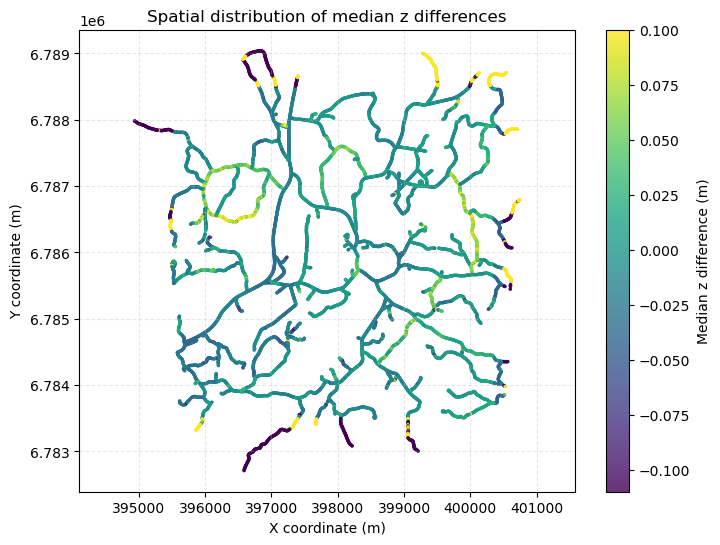

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Example inputs
# xyz_20p: Nx3 array -> columns [x, y, z]
# buffer_of_median_z_diff: list or array of same length as xyz_20p (or one per region)

# Convert to NumPy array if needed
buffer_of_median_z_diff = np.array(buffer_of_median_z_diff)

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,          # X
    middle_points_y,          # Y
    c=buffer_of_median_z_diff,  # Color by z diff
    cmap='viridis',        # or 'viridis', 'RdBu', etc.
    s=2,                    # marker size
    alpha=0.8,
    vmin=0.1, vmax=-0.1
)

plt.colorbar(sc, label="Median z difference (m)")
plt.title("Spatial distribution of median z differences")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # keep aspect ratio true to scale

plt.show()

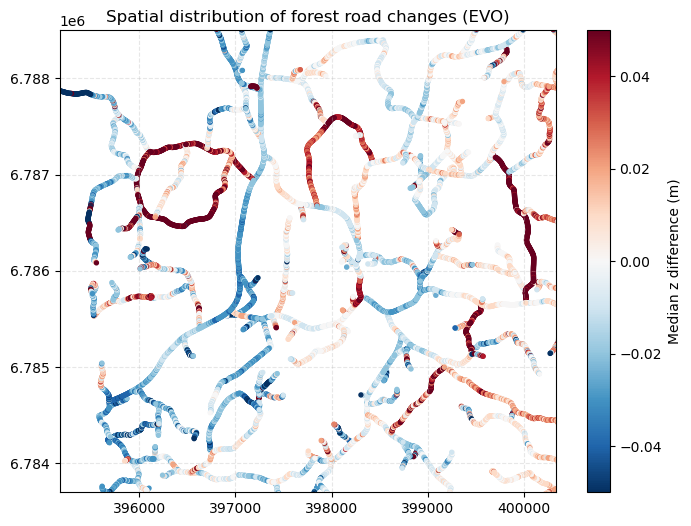

In [6]:
import numpy as np
import matplotlib.pyplot as plt

buffer_of_median_z_diff = np.array(buffer_of_median_z_diff)

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,               # X coordinates
    middle_points_y,               # Y coordinates
    c=buffer_of_median_z_diff,     # Color by z diff
    cmap='RdBu_r',                 # Blue for positive, red for negative
    s=8,                           # Slightly larger for visibility
    alpha=1.0,
    vmin=-0.05, vmax=0.05            # Negative = red, Positive = blue
)

plt.colorbar(sc, label="Median z difference (m)")
plt.title("Spatial distribution of forest road changes (EVO)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # Keep aspect ratio true to scale

plt.xlim([396000, 399500])
plt.ylim([6783700,6788500])

plt.show()

#### Change detection: Surface variation

In [95]:
from scipy.spatial import cKDTree, KDTree

def radius_ball_search(points, radius):
    tree = cKDTree(points)
    neighbors_indices = tree.query_ball_point(points, r=radius)
    return neighbors_indices


def compute_surface_variation(points, neighbors_indices):
    surface_variations = np.zeros(len(points))

    for i, idxs in enumerate(neighbors_indices):
        if len(idxs) < 3:
            surface_variations[i] = np.nan  # not enough points for PCA
            continue

        neighbors = points[idxs]
        centroid = np.mean(neighbors, axis=0)
        centered = neighbors - centroid

        cov = np.cov(centered.T)

        eigvals = np.linalg.eigvalsh(cov)
        eigvals = np.sort(eigvals)

        lam_sum = np.sum(eigvals)
        if lam_sum > 0:
            surface_variations[i] = eigvals[0] / lam_sum
        else:
            surface_variations[i] = 0.0

    return surface_variations


In [96]:
import os
import laspy
import numpy as np

folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches_with_preds"

buffer_of_median_sv_difference = []
buffer_of_mean_sv_difference = []
buffer_of_sv_difference = []
middle_points = []

for file in os.listdir(folder_path_20p):
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_20p = points_20p.prediction
    predictions_5p = points_5p.prediction

    mask_5p = predictions_5p != 1
    xyz_5p_road = xyz_5p[mask_5p]

    mask_20p = predictions_20p != 1
    xyz_20p_road = xyz_20p[mask_20p]

    splitcode_road_5p = points_5p[mask_5p].splitcode

    if mask_5p.sum() > 50:
        tree = KDTree(xyz_20p_road)
        dist, idx = tree.query(xyz_5p_road, k=1)

        # print(idx[:100])
        # print(len(idx))

        neighbor_indices_5p = radius_ball_search(xyz_5p_road, 1.0)
        neighbor_indices_20p = radius_ball_search(xyz_20p_road, 1.0)

        surface_variations_5p = compute_surface_variation(xyz_5p_road, neighbor_indices_5p)
        surface_variations_20p = compute_surface_variation(xyz_20p_road, neighbor_indices_20p)

        # print(len(surface_variations_5p))
        # print(len(surface_variations_20p))

        surface_variations_20p = surface_variations_20p[idx.flatten()]

        # print(len(surface_variations_20p))

        for i in np.unique(splitcode_road_5p):
            splitcode_mask = splitcode_road_5p == i

            xyz_20p_road_reordered = xyz_20p_road[idx.flatten()]

            surface_variation_difference = surface_variations_20p[splitcode_mask] - surface_variations_5p[splitcode_mask]

            buffer_of_sv_difference.append(surface_variation_difference)
            buffer_of_median_sv_difference.append(np.nanmedian(surface_variation_difference))
            buffer_of_mean_sv_difference.append(np.nanmean(surface_variation_difference))

            center_xy = xyz_5p_road[splitcode_mask, :2].mean(axis=0) 
            middle_points.append(center_xy)

Nan values 4 / 17861
nan


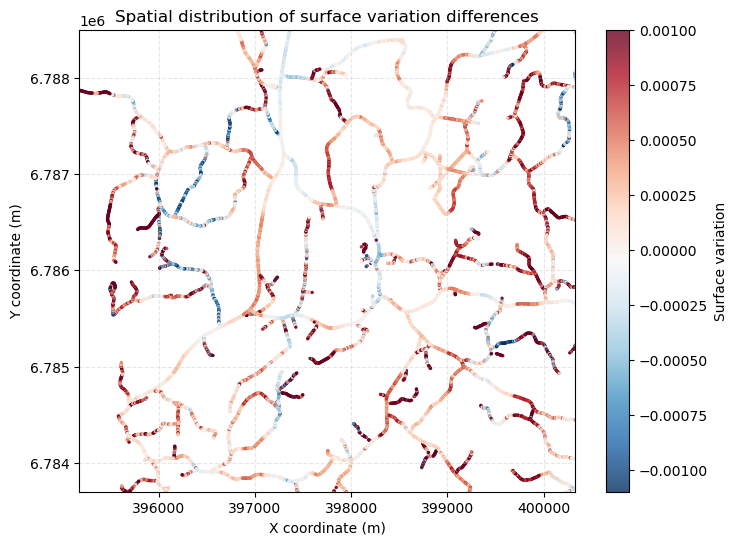

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array if needed
buffer_of_median_sv_difference = np.array(buffer_of_median_sv_difference)

nan_count = np.isnan(buffer_of_median_sv_difference).sum()

print(f"Nan values {nan_count} / {len(buffer_of_median_sv_difference)}")

print(np.median(buffer_of_median_sv_difference))

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]


plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,          # X
    middle_points_y,          # Y
    c=buffer_of_median_sv_difference,
    cmap='RdBu_r',                 # Blue for positive, red for negative
    s=2,                    # marker size
    alpha=0.8,
    vmin=0.001, vmax=-0.001
)

plt.colorbar(sc, label="Surface variation")
plt.title("Spatial distribution of surface variation differences")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # keep aspect ratio true to scale

plt.xlim([396000, 399500])
plt.ylim([6783700,6788500])

plt.show()

Correlation coefficient: nan


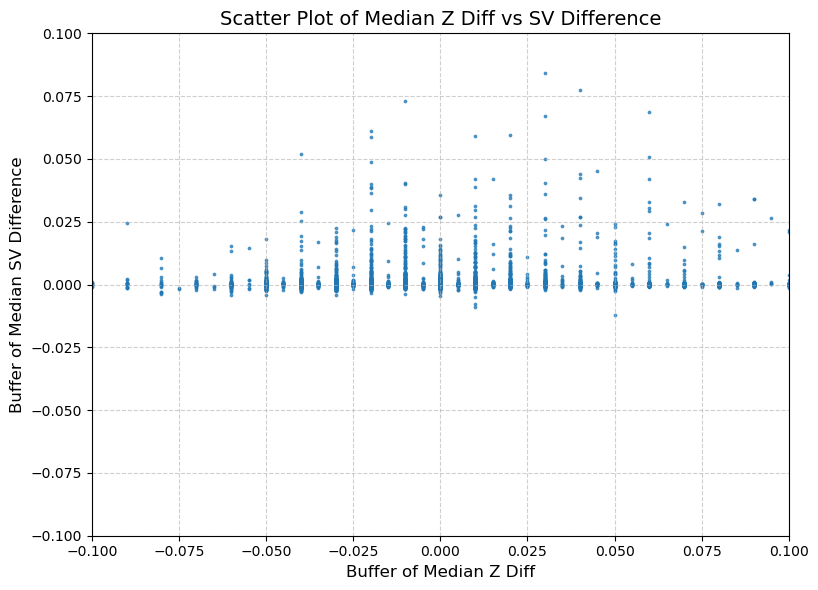

In [21]:
import matplotlib.pyplot as plt


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(buffer_of_median_z_diff, buffer_of_median_sv_difference, s=3, alpha=0.7)

corr = np.corrcoef(buffer_of_median_z_diff, buffer_of_median_sv_difference)[0, 1]
print(f"Correlation coefficient: {corr:.3f}")

# Add titles and labels
plt.title('Scatter Plot of Median Z Diff vs SV Difference', fontsize=14)
plt.xlabel('Buffer of Median Z Diff', fontsize=12)
plt.ylabel('Buffer of Median SV Difference', fontsize=12)

# Optional: grid and equal aspect
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.xlim([-0.1, 0.1])
plt.ylim([-0.1,0.1])

# Show plot
plt.show()



In [ ]:
import numpy as np
import py4dgeo
import py4dgeo.util
import laspy

# --- Load data ---
def load_las(filename):
    las = laspy.read(filename)
    return np.vstack((las.x, las.y, las.z)).T

cloud = load_las(r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions\461795483_19150.laz")   # used for M3C2 core points
cloud2 = load_las(r"E:\ALS_DATA\NLS_20p_EVO_road_patches\461795483_19150.las")        # "After"

epoch1, epoch2 = py4dgeo.read_from_las(
    r"C:\Users\telukkari\Documents\Data\5p_example.las", r"C:\Users\telukkari\Documents\Data\20p_example.las"
)


corepoints = epoch1.cloud

m3c2 = py4dgeo.M3C2(
    epochs=(epoch1, epoch2),
    corepoints=corepoints,
    cyl_radius=1.0,
    normal_radii=[1.0,1.5],
    registration_error=(0.006)
)


distances, uncertainties = m3c2.run()

print(f"Median M3C2 distances: {np.nanmedian(distances):.3f} m")
print(f"Std. dev. of M3C2 distances: {np.nanstd(distances):.3f} m")

print(uncertainties)
print(uncertainties["lodetection"][:100])
print(np.max(uncertainties["lodetection"]))
print(uncertainties["num_samples1"][:100])
print(uncertainties["num_samples2"][:100])

print("M3C2 distances:", distances[:10])
# print("M3C2 mean distance:", np.mean(distances))
# print("M3C2 median distance:", np.median(distances))
# print(cloud1.shape, cloud2.shape)
# print("Length of M3C2 distances:", len(distances))
# directions = m3c2.directions()
# print(directions[:100])


[2025-11-05 09:54:20][INFO] Reading point cloud from file 'C:\Users\telukkari\Documents\Data\5p_example.las'
[2025-11-05 09:54:20][INFO] Reading point cloud from file 'C:\Users\telukkari\Documents\Data\20p_example.las'
[2025-11-05 09:54:20][INFO] Building KDTree structure with leaf parameter 10
[2025-11-05 09:54:20][INFO] Building KDTree structure with leaf parameter 10
Median M3C2 distances: 0.010 m
Std. dev. of M3C2 distances: 0.016 m
[(0.02235312, 0.01376824, 20, 0.02350528, 28)
 (0.02929813, 0.0137701 , 17, 0.037125  , 20)
 (0.02637346, 0.01413118, 15, 0.03185352, 24) ...
 (0.0248284 , 0.02937114, 22, 0.0222027 , 94)
 (0.0295819 , 0.03089414, 19, 0.05373646, 89)
 (0.03301028, 0.03102331, 16, 0.06776171, 80)]
[0.02235312 0.02929813 0.02637346 0.02027594 0.02281877 0.02278762
 0.01999171 0.01944792 0.01985948 0.02082084 0.0205871  0.0204678
 0.0202075  0.01897295 0.01846386 0.0200718  0.02049155 0.02052526
 0.01989653 0.01934253 0.01964274 0.01993162 0.01964534 0.01946094
 0.01886456

#### Change detection: M3C2 distances

In [90]:
import laspy 
import numpy as np
import os
from sklearn.neighbors import KDTree

folder_path_5p = r"E:\ALS_DATA\NLS_5p_PADASJOKI_road_patches\laz_files_split_along_road_vectors_with_dl_predictions"
folder_path_20p = r"E:\ALS_DATA\NLS_20p_EVO_road_patches_with_preds"

buffer_of_mean_distances = []
buffer_of_median_distances = []
buffer_of_distances = []
middle_points = []

for file in os.listdir(folder_path_20p):
    data_5p_laz = os.path.splitext(file)[0] + ".laz"

    data_5p = os.path.join(folder_path_5p, data_5p_laz)
    data_20p = os.path.join(folder_path_20p, file)

    points_5p = laspy.read(data_5p)
    points_20p = laspy.read(data_20p)

    xyz_5p = np.vstack((points_5p.x, points_5p.y, points_5p.z)).T
    xyz_20p = np.vstack((points_20p.x, points_20p.y, points_20p.z)).T

    predictions_5p = points_5p.prediction

    mask = predictions_5p != 1
    xyz_5p_road = xyz_5p[mask]

    splitcode_5p = points_5p[mask].splitcode

    predictions_20p = points_20p.prediction

    mask_20p = predictions_20p != 1
    xyz_20p_road = xyz_20p[mask_20p]

    epoch1 = py4dgeo.Epoch(xyz_5p_road)
    epoch2 = py4dgeo.Epoch(xyz_20p_road)

    corepoints = epoch1.cloud

    m3c2 = py4dgeo.M3C2(
        epochs=(epoch1, epoch2),
        corepoints=corepoints,
        cyl_radius=1.0,
        normal_radii=[1.0,1.5],
        registration_error=(0.006)
    )

    distances, uncertainties = m3c2.run()

    # print(f"Median M3C2 distances: {np.nanmedian(distances):.3f} m")
    # print(f"Std. dev. of M3C2 distances: {np.nanstd(distances):.3f} m")


    for i in np.unique(splitcode_5p):
        # z_diff = xyz_20p[idx.flatten(), 2] - xyz_5p_road[:, 2]

        splitcode_mask = splitcode_5p == i
        distances_masked = distances[splitcode_mask]

        buffer_of_distances.append(distances_masked)
        buffer_of_median_distances.append(np.median(distances_masked))
        buffer_of_mean_distances.append(np.mean(distances_masked))

        center_xy = xyz_5p_road[splitcode_mask, :2].mean(axis=0)
        middle_points.append(center_xy)


[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10
[2025-11-04 13:52:48][INFO] Building KDTree structure with leaf parameter 10

Nan values 2011 / 17861
nan


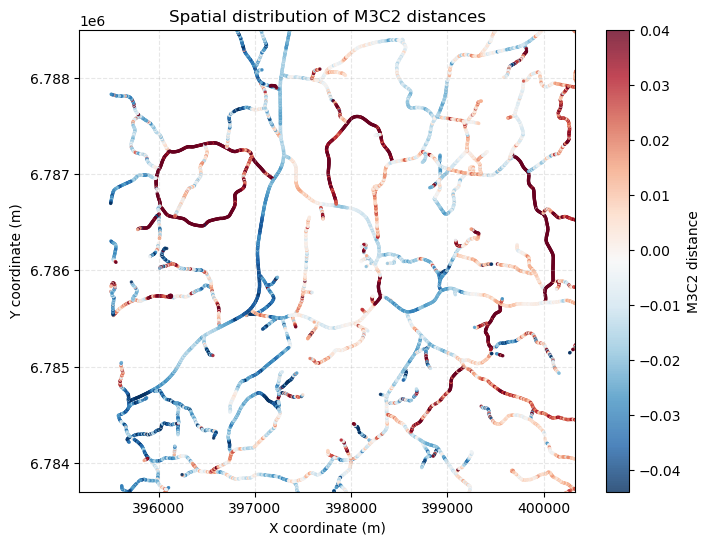

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to NumPy array if needed
buffer_of_median_distances = np.array(buffer_of_median_distances)

nan_count = np.isnan(buffer_of_median_distances).sum()

print(f"Nan values {nan_count} / {len(buffer_of_median_distances)}")

print(np.median(buffer_of_median_distances))

middle_points_x = [point[0] for point in middle_points]
middle_points_y = [point[1] for point in middle_points]


plt.figure(figsize=(8, 6))
sc = plt.scatter(
    middle_points_x,          # X
    middle_points_y,          # Y
    c=buffer_of_median_distances,
    cmap='RdBu_r',                 # Blue for positive, red for negative
    s=2,                    # marker size
    alpha=0.8,
    vmin=0.04, vmax=-0.04
)

plt.colorbar(sc, label="M3C2 distance")
plt.title("Spatial distribution of M3C2 distances")
plt.xlabel("X coordinate (m)")
plt.ylabel("Y coordinate (m)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')  # keep aspect ratio true to scale

plt.xlim([396000, 399500])
plt.ylim([6783700,6788500])

plt.show()